# 1. 資料整理

In [1]:
### Importing necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation
from sklearn.metrics.pairwise import pairwise_distances
import ipywidgets as widgets
from IPython.display import display, clear_output
from contextlib import contextmanager
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os, sys
import re
import seaborn as sns
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [2]:
### Loading data
books = pd.read_csv('books.csv', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 
                 'imageUrlS', 'imageUrlM', 'imageUrlL','Book-Description'] # rename the column if you want
users = pd.read_csv('users.csv', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('book_ratings_train.csv', error_bad_lines=False, encoding="latin-1")
ratings.columns = [ 'userID','ISBN', 'bookRating']

# dropping last three columns containing image URLs which will not be required for analysis
books.drop(['imageUrlS', 'imageUrlM', 'imageUrlL'],axis=1,inplace=True)

# making this setting to display full text in columns
pd.set_option('display.max_colwidth', -1)

#books.head() # check the dataframe if you want
#users.head() # check the dataframe if you want

b'Skipping line 7842: expected 9 fields, saw 12\n'
b'Skipping line 70346: expected 9 fields, saw 14\n'
b'Skipping line 135984: expected 9 fields, saw 19\nSkipping line 189418: expected 9 fields, saw 16\n'
b'Skipping line 214386: expected 9 fields, saw 17\n'


## Book Data
### year of publication

In [3]:
#yearOfPublication should be set as having dtype as integer
#checking the unique values of yearOfPublication
books.yearOfPublication.unique()

#as it can be seen from below that there are some incorrect entries in this field. It looks like Publisher names 
#'DK Publishing Inc' and 'Gallimard' have been incorrectly loaded as yearOfPublication in dataset due to some errors in csv file
#Also some of the entries are strings and same years have been entered as numbers in some places

# Correcting the dtypes of yearOfPublication
books.yearOfPublication=pd.to_numeric(books.yearOfPublication, errors='coerce')

# Now it can be seen that yearOfPublication has all values as integers, so it can be sorted
sorted(books['yearOfPublication'].unique())

#However, the value 0 is invalid and as this dataset was published in 2004, I have assumed the the years after 2006 to be 
#invalid keeping some margin in case dataset was updated thereafer
#setting invalid years as NaN
books.loc[(books.yearOfPublication > 2006) | (books.yearOfPublication == 0),'yearOfPublication'] = np.NAN

#replacing NaNs with mean value of yearOfPublication
books.yearOfPublication.fillna(round(books.yearOfPublication.mean()), inplace=True)

#rechecking
books.yearOfPublication.isnull().sum()
#No NaNs

#resetting the dtype as int32
books.yearOfPublication = books.yearOfPublication.astype(np.int32)

### publisher

In [4]:
#exploring 'publisher' column
books.loc[books.publisher.isnull(),:]
#two NaNs
#investigating rows having NaNs
#Checking with rows having bookTitle as Tyrant Moon to see if we can get any clues
books.loc[(books.bookTitle == 'Tyrant Moon'),:]
#no clues

#Checking with rows having bookTitle as Finder Keepers to see if we can get any clues
books.loc[(books.bookTitle == 'Finders Keepers'),:]
#all rows with different publisher and bookAuthor

#checking by bookAuthor to find patterns
books.loc[(books.bookAuthor == 'Elaine Corvidae'),:]
#all having different publisher...no clues here

#checking by bookAuthor to find patterns
books.loc[(books.bookAuthor == 'Linnea Sinclair'),:]

#since there is nothing in common to infer publisher for NaNs, replacing these with 'other
books.loc[(books.ISBN == '193169656X'),'publisher'] = 'other'
books.loc[(books.ISBN == '1931696993'),'publisher'] = 'other'

## Users Data
### userID

In [5]:
#users.head() # check the dataframe if you want
#users.dtypes

users.userID.values #it can be seen that these are unique

array(['7c9fa136d4', 'd86e8112f3', '35be322d09', ..., '525b74f9cf',
       '1fe052a9d0', '514d852b64'], dtype=object)

###  Location

In [6]:
#users.Location.head() # check the dataframe if you want
users = pd.read_csv('users.csv', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age'] 

# extract the country info. from Location variable
users['Country'] = users['Location'].str.split(',').str[2] 

# since the extracted result contain many mistakes, we should modify it manually....
users.loc[(users.Country==' n/a')|(users.Country==' x')|(users.Country==' n/a - on the road')|
          (users.Country==' far away...')|(users.Country==' &#20013;&#22269;')|(users.Country==' \"n/a\""')|
          (users.Country=='"')|(users.Country==' ```n/a``')|(users.Country==' \n/a\"')|
          (users.Country==' *'),'Country']=' '
users.loc[(users.Country ==' austria"')|(users.Country=='austria'),'Country']=' austria'
users.loc[users.Country ==' spain"','Country']=' spain'
users.loc[(users.Country ==' italia')|(users.Country==' italy'),'Country']=' italy'
users.loc[users.Country ==' portugal"','Country']=' portugal'
users.loc[users.Country ==' switzerland"','Country']=' switzerland'
users.loc[(users.Country ==' united kingdom"')|(users.Country==' united kindgom')|
          (users.Country==' u.k.')|(users.Country==' england'),'Country']=' united kingdom'
users.loc[(users.Country ==' us')|(users.Country==' us>')|(users.Country==' u.s.a.')|(users.Country==' u.s. of a.')|
          (users.Country==' united state')|(users.Country==' united states')|(users.Country==' united states of america'),'Country']=' usa'
users.loc[users.Country ==' netherlands"','Country']=' netherlands'
users.loc[users.Country ==' new zealand"','Country']=' new zealand'
users.loc[users.Country ==' germany"','Country']=' germany'
users.loc[users.Country ==' cananda"','Country']=' canada'
users.loc[users.Country ==' france"','Country']=' france'
users.loc[users.Country ==' denmark"','Country']=' denmark'
users.loc[users.Country ==' greece"','Country']=' greece'
users.loc[users.Country ==' _ brasil','Country']=' brazil'
users.loc[users.Country ==' ireland"','Country']=' ireland'
users.loc[users.Country ==' norway"','Country']=' norway'
users.loc[(users.Country =='  philippines"')|(users.Country==' phillipines'),'Country']=' philippines'
users.loc[users.Country ==' sweden"','Country']=' sweden'
countryCount=users.groupby('Country')['Country'].agg(['count'])
countryCount['Country']=countryCount.index # re-index so as to merge with user data
users=users.merge(countryCount,left_on='Country',right_on='Country',how='left')
users.count=users["count"].astype(np.float64)
users.loc[users.count<60 ,'Country']=' others' 
# we set the count of Taiwan=60 as the lower bound, if the count of country is lower than 60, considering it as the country label "others"
users.drop(['count'],axis=1,inplace=True)

# one-hot code for the country
users = pd.get_dummies(users, columns=['Country'])

#user.head() # check the dataframe if you want

### Age

In [7]:
print (sorted(users.Age.unique()))
#Age column has some invalid entries like nan, 0 and very high values like 100 and above

#In my view values below 5 and above 90 do not make much sense for our book rating case...hence replacing these by NaNs
users.loc[(users.Age > 90) | (users.Age < 5), 'Age'] = np.nan

# Create the age group
users['AgeGroup']=''
users.loc[(users.Age <=20) , 'AgeGroup'] = 'below20'
users.loc[(users.Age >20) & (users.Age<=30) , 'AgeGroup'] = '21~30'
users.loc[(users.Age >30) & (users.Age<=40) , 'AgeGroup'] = '31~40'
users.loc[(users.Age >40) & (users.Age<=50) , 'AgeGroup'] = '41~50'
users.loc[(users.Age >50) & (users.Age<=60) , 'AgeGroup'] = '51~60'
users.loc[(users.Age >60) & (users.Age<=70) , 'AgeGroup'] = '61~70'
users.loc[(users.Age >70) & (users.Age<=80) , 'AgeGroup'] = '71~80'
users.loc[(users.Age >80) , 'AgeGroup'] = '80up'
users.loc[(users.AgeGroup=='') , 'AgeGroup'] = 'unknown'
users = pd.get_dummies(users, columns=['AgeGroup'])

#replacing NaNs with mean
users.Age = users.Age.fillna(users.Age.mean())

#setting the data type as int
users.Age = users.Age.astype(np.int32)

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

## Ratings Dataset

75676484040
(260202, 3)
(260202, 3)
(260202, 3)
(260202, 3)
number of users: 278858
number of books: 271380
(260202, 3)
(260202, 3)
(0, 3)


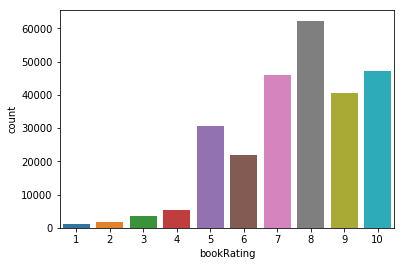

Following books are recommended


In [8]:
#checking shape
ratings = pd.read_csv('book_ratings_train.csv', error_bad_lines=False, encoding="latin-1")
ratings.columns = [ 'userID','ISBN', 'bookRating']
ratings.shape

#ratings dataset will have n_users*n_books entries if every user rated every item, this shows that the dataset is very sparse
n_users = users.shape[0]
n_books = books.shape[0]
print (n_users * n_books)

#checking first few rows...
ratings.head(5)

ratings.bookRating.unique()

#ratings dataset should have books only which exist in our books dataset, unless new books are added to books dataset
#ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]
ratings_new = ratings

print (ratings.shape)
print (ratings_new.shape)
#it can be seen that many rows having book ISBN not part of books dataset got dropped off

#ratings dataset should have ratings from users which exist in users dataset, unless new users are added to users dataset
ratings = ratings[ratings.userID.isin(users.userID)]

print (ratings.shape)
print (ratings_new.shape)
#no new users added, hence we will go with above dataset ratings_new (1031136, 3)

print ("number of users: " + str(n_users))
print ("number of books: " + str(n_books))

#Sparsity of dataset in %
sparsity=1.0-len(ratings_new)/float(n_users*n_books)
sparsity

#As quoted in the description of the dataset -
#BX-Book-Ratings contains the book rating information. Ratings are either explicit, expressed on a scale from 1-10 
#higher values denoting higher appreciation, or implicit, expressed by 0
ratings.bookRating.unique()

#Hence segragating implicit and explict ratings datasets
ratings_explicit = ratings_new[ratings_new.bookRating != 0]
ratings_implicit = ratings_new[ratings_new.bookRating == 0]

#checking shapes
print (ratings_new.shape)
print (ratings_explicit.shape)
print (ratings_implicit.shape)

#plotting count of bookRating
sns.countplot(data=ratings_explicit , x='bookRating')
plt.show()
#It can be seen that higher ratings are more common amongst users and rating 8 has been rated highest number of times

ratings_explicit.describe()

#At this point , a simple popularity based recommendation system can be built based on count of user ratings for different books
ratings_count = pd.DataFrame(ratings_explicit.groupby(['ISBN'])['bookRating'].sum())
top10 = ratings_count.sort_values('bookRating', ascending = False).head(10)
print ("Following books are recommended")
top10.merge(books, left_index = True, right_on = 'ISBN')

#Given below are top 10 recommendations based on popularity. It is evident that books authored by J.K. Rowling are most popular

#Similarly segregating users who have given explicit ratings from 1-10 and those whose implicit behavior was tracked
users_exp_ratings = users[users.userID.isin(ratings_explicit.userID)]
users_imp_ratings = users[users.userID.isin(ratings_implicit.userID)]

# 2. 模型分析
## 輸入資料處理

In [9]:
imp_ratings = pd.read_csv('implicit_ratings.csv', error_bad_lines=False, encoding="latin-1")
imp_ratings.columns = [ 'bookRating','ISBN','userID']
#imp_ratings.head() # check the dataframe if you want

# load the test data
test_data = pd.read_csv('book_ratings_test.csv', error_bad_lines=False, encoding="latin-1")
test_data.columns = ['userID','ISBN']
#test_data.head() # check the data if you want


In [10]:
test_new = test_data[test_data.ISBN.isin(books.ISBN)]
test_new.shape
a =  test_data.ISBN.isin(books.ISBN)
b= [not c for c in a]

test_new2 = test_data[b]
test_new2.shape

(141234, 2)

In [11]:
# caculate mean, standard error and number of rating, grouped by users and books
bookMeanRate=ratings_explicit.groupby('ISBN')['bookRating'].agg(['mean','std','count'])
bookMeanRate['ISBN']=bookMeanRate.index # re-index it so as to megre with user data
userMeanRate=ratings_explicit.groupby('userID')['bookRating'].agg(['mean','std','count'])
userMeanRate['userID']=userMeanRate.index # re-index it so as to merge with book data

In [12]:
# clculate the number of implicit rating, grouped by users and books 
userImpMeanRate=imp_ratings.groupby('userID')['bookRating'].agg(['mean','std','count'])
userImpMeanRate.drop(['mean', 'std'],axis=1,inplace=True)
userImpMeanRate.columns = [ 'NumOfImp']
userImpMeanRate['userID']=userImpMeanRate.index # re-index it so as to megre with user data
#userImpMeanRate.head() # check the dataframe if you want
bookImpMeanRate=imp_ratings.groupby('ISBN')['bookRating'].agg(['mean','std','count'])
bookImpMeanRate.drop(['mean', 'std'],axis=1,inplace=True)
bookImpMeanRate.columns = [ 'NumOfImp']
bookImpMeanRate.head()
bookImpMeanRate['ISBN']=bookImpMeanRate.index # re-index it so as to merge with book data
#bookImpMeanRate.head()

In [13]:
# merge with users and books data
new_users=users.merge(userMeanRate,left_on='userID',right_on='userID',how='left')
new_books=books.merge(bookMeanRate,left_on='ISBN',right_on='ISBN',how='left')
new_users=new_users.merge(userImpMeanRate,left_on='userID',right_on='userID',how='left')
new_books=new_books.merge(bookImpMeanRate,left_on='ISBN',right_on='ISBN',how='left')

In [14]:
# upadted our dataset by data crawled by kuo
# this part is not allowed in the spec. actually
books_updated = pd.read_csv('books_final.csv', error_bad_lines=False, encoding="latin-1")
books_updated.drop(['Unnamed: 0', 'publisher'],axis=1,inplace=True)
books_updated.rename(columns={'yearOfPublication': 'YearPubNew', 'decriptionLen': 'DecrLenNew'}, inplace=True)
books_updated['form'] = books_updated.form.replace(np.NaN, 'unknown')
books_updated['shelve1'] = books_updated.shelve1.replace(np.NaN, 'unknown')
books_updated=books_updated.drop_duplicates(['ISBN'], keep='first')
new_books=new_books.merge(books_updated,left_on='ISBN',right_on='ISBN',how='left')

#books_updated.head() # check the dataframe if you want



### Length of Decription

In [15]:
description_words=new_books['Book-Description'].str.split()
description_words = pd.DataFrame(description_words)
#description_words.head()
new_books['decriptionLen']=description_words['Book-Description'].str.len()


In [16]:
# update the data
new_books.loc[(new_books.yearOfPublication==np.NaN) | (new_books.yearOfPublication==None), 'yearOfPublication'] = new_books.YearPubNew
new_books.loc[new_books.decriptionLen==np.NaN, 'decriptionLen'] = new_books.DecrLenNew
new_books.drop(['YearPubNew', 'DecrLenNew'],axis=1,inplace=True)
new_books = pd.get_dummies(new_books, columns=['form'])
new_books = pd.get_dummies(new_books, columns=['shelve1'])
#users.loc[(users.Age >20) & (users.Age<=30) , 'AgeGroup'] = '21~30'

In [17]:
### merge data to complete the train data
#book_feature=['ISBN', 'yearOfPublication', 'mean', 'std', 'count', 'decriptionLen','NumOfImp']
book_feature=list(new_books)
book_feature.remove('bookTitle')
book_feature.remove('bookAuthor')
book_feature.remove('Book-Description')

user_feature=list(new_users)
user_feature.remove('Location')
#user_feature=['userID', 'AgeGroup' ,'Age', 'mean', 'std', 'count','NumOfImp','Country']
#user_feature=['userID', 'AgeGroup_below20','AgeGroup_21~30','AgeGroup_31~40','AgeGroup_41~50','AgeGroup_51~60','AgeGroup_61~70',
#              'AgeGroup_71~80','AgeGroup_80up','AgeGroup_unknown','Age', 'mean', 'std', 'count','NumOfImp']
train = ratings_explicit.merge(new_books.loc[:,book_feature],left_on='ISBN',right_on='ISBN',how='left')
train = train.merge(new_users.loc[:,user_feature],left_on='userID',right_on='userID',how='left')
#train = train[train['count_x'] >= 2] 
#train = train[train['count_y'] >= 2] 
#train = train.drop(train.count_y<200, inplace=True, axis=1)

#train.head() # check the data if you want

# 3. Train Model

In [19]:
features=list(train)
features.remove('userID')
features.remove('ISBN')
features.remove('bookRating')
features.remove('publisher')
#features=['yearOfPublication', 'mean_x', 'std_x','count_x', 'decriptionLen', 'Age', 'mean_y', 'std_y', 'count_y', 
#          'NumOfImp_x', 'NumOfImp_y','AgeGroup_below20','AgeGroup_21~30','AgeGroup_31~40','AgeGroup_41~50','AgeGroup_51~60','AgeGroup_61~70',
#              'AgeGroup_71~80','AgeGroup_80up','AgeGroup_unknown']
#le = preprocessing.LabelEncoder()
#le = le.fit(train.loc[:, 'AgeGroup'])
#train_imputed = le.fit_transform(train.loc[:, 'AgeGroup'])

imputer = preprocessing.Imputer(missing_values='NaN', strategy='median', axis=0, copy=False)
imputer = imputer.fit(train.loc[:, features])
train_imputed = imputer.fit_transform(train.loc[:, features])

In [24]:
train.head()

,userID,ISBN,bookRating,yearOfPublication,publisher,mean_x,std_x,count_x,NumOfImp_x,average_rating,...,AgeGroup_51~60,AgeGroup_61~70,AgeGroup_71~80,AgeGroup_80up,AgeGroup_below20,AgeGroup_unknown,mean_y,std_y,count_y,NumOfImp_y
0,153d612c88,1550372289,8,1992.0,Annick Press,8.0,NaN,1.0,1.0,4.11,...,0,0,0,0,0,0,7.332278,1.179743,632.0,1386.0
1,f73f18a13a,030796017X,10,2001.0,Golden Books,10.0,NaN,1.0,3.0,4.21,...,0,0,0,0,0,1,7.513514,1.865202,37.0,271.0
2,02e87fe603,014028009,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,8.500000,0.755929,8.0,1.0
3,be36e5b8cb,0345413350,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,10.000000,NaN,1.0,3.0
4,98ec1c54b5,0609600788,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,9.461538,0.776250,13.0,NaN


In [18]:
# import the packages
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

In [86]:
# split to train set & validation set
x_train,x_test,y_train,y_test = train_test_split(train_imputed,train.loc[:, 'bookRating'],test_size=0.99, random_state=42)


rfr = RandomForestRegressor(n_estimators = 1000, random_state = 42,n_jobs=-1,criterion='mae')
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42,n_jobs=-1)
ada = AdaBoostClassifier(n_estimators = 1000, random_state = 42, )

#rf = RandomForestClassifier(n_estimators = 1000, random_state = 42,n_jobs=-1, 
#                            class_weight={1:1.5, 2:1.5, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1})
# Train the model on training data
rfr.fit(x_train, y_train);
rfr.score(x_train, y_train)

rf.fit(x_train, y_train);
rf.score(x_train, y_train)

ada.fit(x_train, y_train);
ada.score(x_train, y_train)

0.324750192159877

In [87]:
# performance on the validation set
rfr.score(x_test, y_test)
rf.score(x_test, y_test)
ada.score(x_test, y_test)

0.32777950310559006

In [88]:
# test data process

test = test_data.merge(new_books.loc[:,book_feature],left_on='ISBN',right_on='ISBN',how='left')
test = test.merge(new_users.loc[:,user_feature],left_on='userID',right_on='userID',how='left')
test_imputed = imputer.fit_transform(test.loc[:, features])

#test.head() # check the dataframe if you want

In [89]:
# test predict: choose one to implement
test_data['bookRating']=rfr.predict(test_imputed)
test_data['bookRating']=rf.predict(test_imputed)
test_data['bookRating']=ada.predict(test_imputed)

In [90]:
# submission

test_data['bookRating']=round(test_data.bookRating)
test_data.bookRating=test_data["bookRating"].astype(np.int64)
submiss = pd.DataFrame(test_data['bookRating'])
submiss.to_csv('submission.csv',header=False,index=False)

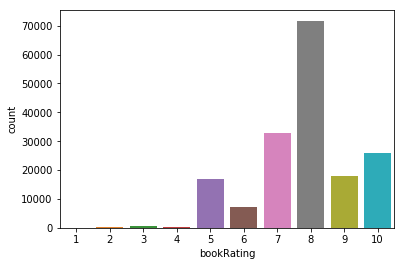

In [91]:
test_data.head() # check the result if you want

# plot the predicted result
sns.countplot(data=test_data , x='bookRating')
plt.show()